## Vector Autoregression

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(3)

In [3]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [4]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [107]:
df_elec_data = pd.concat([loaded_elec_data["df_elec_train"], loaded_elec_data["df_elec_validate"], loaded_elec_data["df_elec_test"]])
df_elec_data = df_elec_data.resample("D").mean()

df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec_data)
df_elec_test.shape

/home/ivan/anaconda3/envs/weather-prediction/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(584, 4)

### Sanity Check

In [108]:
assert loaded_heat_data["df_heat_train"].shape == (49056, 6)
assert loaded_heat_data["df_heat_test"].shape == (14017, 6)
assert loaded_heat_data["df_heat_validate"].shape == (7007, 6)

assert loaded_elec_data["df_elec_train"].shape == (49056, 4)
assert loaded_elec_data["df_elec_test"].shape == (14017, 4)
assert loaded_elec_data["df_elec_validate"].shape == (7007, 4)


In [109]:
def display_time_series(df_train, df_validate, df_test, col="", figsize=(15,5), title="", ):
    ax = df_train[col].plot(figsize=figsize, color="tab:blue", label="Train")
    _ = df_test[col].plot(ax=ax, color="tab:red", label="Test")
    _ = df_validate[col].plot(ax=ax, color="tab:orange", label="Validate")
    
    ax.legend()
    ax.axvline(df_validate.index[0], linestyle=":")
    ax.axvline(df_test.index[0], linestyle=":")
    
    plt.title(title)
    plt.show()

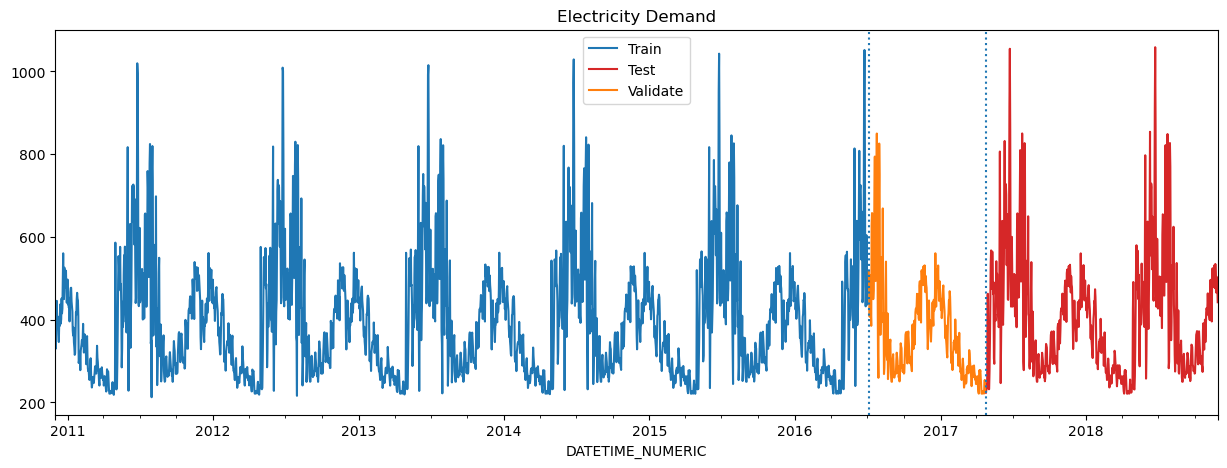

In [110]:
# display_time_series(df_heat_train, df_heat_validate, df_heat_test, col="heat_demand_values[kw]", title="Heat Demand")
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")

## Predicting Electricity Demand

In [111]:
print(f"Train Period: {df_elec_train.index.min()}      ===> {df_elec_train.index.max()} shape: {df_elec_train.shape}")
print(f"Validation Period: {df_elec_validate.index.min()} ===> {df_elec_validate.index.max()} shape: {df_elec_validate.shape}")
print(f"Test Period: {df_elec_test.index.min()}       ===> {df_elec_test.index.max()} shape: {df_elec_test.shape}")


Train Period: 2010-12-01 00:00:00      ===> 2016-07-04 00:00:00 shape: (2043, 4)
Validation Period: 2016-07-05 00:00:00 ===> 2017-04-23 00:00:00 shape: (293, 4)
Test Period: 2017-04-24 00:00:00       ===> 2018-11-28 00:00:00 shape: (584, 4)


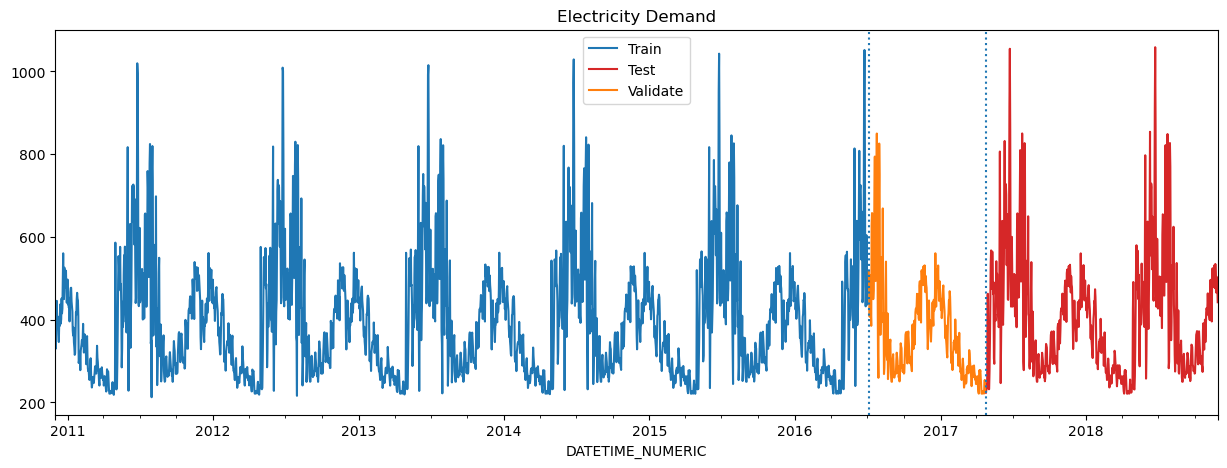

In [112]:
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")


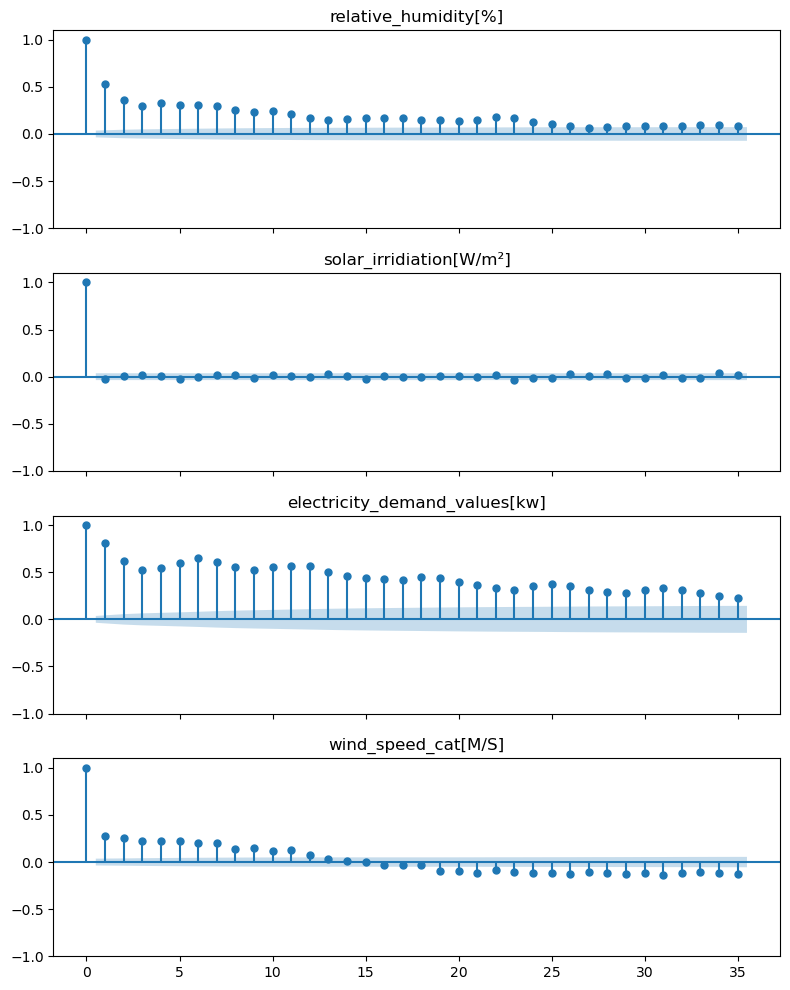

In [113]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)
axes = axes.flat
for i, col in enumerate(df_elec_data.columns):
    plot_acf(df_elec_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

# The *naive* approach

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [115]:
X_train = df_elec_train.drop(columns="electricity_demand_values[kw]")
y_train = df_elec_train["electricity_demand_values[kw]"]

X_test = df_elec_test.drop(columns="electricity_demand_values[kw]")
y_test = df_elec_test["electricity_demand_values[kw]"]


In [116]:
X_train

,relative_humidity[%],solar_irridiation[W/m²],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,
2010-12-01,76.666667,266.833333,3.833333
2010-12-02,71.750000,271.916667,6.541667
2010-12-03,71.500000,239.291667,4.708333
2010-12-04,58.250000,271.791667,6.375000
2010-12-05,44.416667,260.750000,5.500000
...,...,...,...
2016-06-30,69.000000,267.666667,6.125000
2016-07-01,61.833333,259.791667,6.125000
2016-07-02,51.875000,271.625000,2.875000


In [117]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [118]:
y_pred = model.predict(X_test)

In [119]:
mape = mean_absolute_percentage_error(y_test, y_pred)

In [120]:
y_pred_mapped = pd.Series(y_pred, index=y_test.index)

In [121]:
y_pred_mapped

DATETIME_NUMERIC
2017-04-24    387.164626
2017-04-25    395.882440
2017-04-26    403.039231
2017-04-27    389.557052
2017-04-28    388.162823
                 ...    
2018-11-24    412.029665
2018-11-25    388.366386
2018-11-26    373.166729
2018-11-27    413.197739
2018-11-28    396.587886
Freq: D, Length: 584, dtype: float64

In [122]:
print(f"MAPE: {mape}")

MAPE: 0.27122910830766256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 750x750 with 0 Axes>

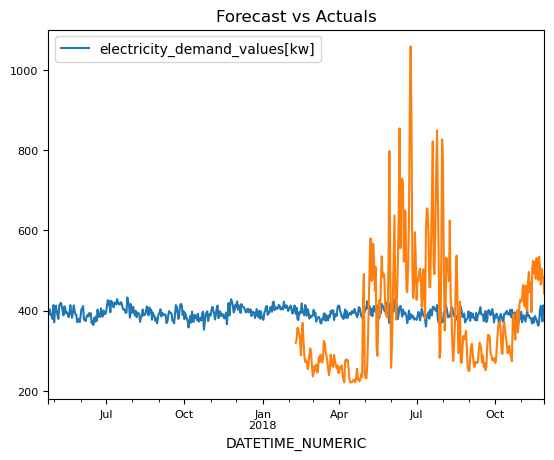

In [123]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
pd.DataFrame({"electricity_demand_values[kw]": y_pred_mapped}).plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)

## Modelling a multi-variate Timeseries

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

In [125]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-01,76.666667,266.833333,356.243842,3.833333
2010-12-02,71.750000,271.916667,329.619600,6.541667
2010-12-03,71.500000,239.291667,364.953960,4.708333
2010-12-04,58.250000,271.791667,417.211125,6.375000
2010-12-05,44.416667,260.750000,445.594869,5.500000


In [126]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoregMultiVariate(
    regressor         = RandomForestRegressor(random_state=42),
    lags              = 72,
    transformer_series= StandardScaler(),
    level             = "electricity_demand_values[kw]",
    steps             = 10
)

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_elec_data,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/84 [00:00<?, ?it/s]

In [127]:
print("Backtest metrics")
display(multi_series_mae)
print("")
print("Backtest predictions")
predictions_ms.head(4)

Backtest metrics


,levels,mean_absolute_error
0,electricity_demand_values[kw],19.764201



Backtest predictions


,electricity_demand_values[kw]
2017-04-24,230.953514
2017-04-25,222.240554
2017-04-26,233.886483
2017-04-27,240.864157


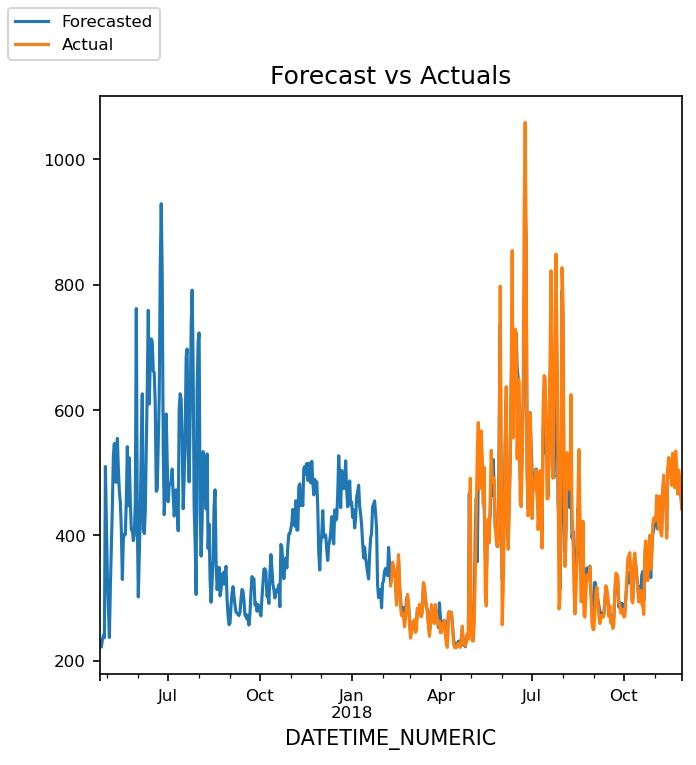

In [128]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
predictions_ms["electricity_demand_values[kw]"].plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [130]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-01,76.666667,266.833333,356.243842,3.833333
2010-12-02,71.750000,271.916667,329.619600,6.541667
2010-12-03,71.500000,239.291667,364.953960,4.708333
2010-12-04,58.250000,271.791667,417.211125,6.375000
2010-12-05,44.416667,260.750000,445.594869,5.500000


In [131]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoreg(
    regressor         = RandomForestRegressor(random_state=42),
    lags              = 72,
)

single_series_mae, predictions_ss = backtesting_forecaster(
                                       forecaster         = forecaster_ms,
                                       y                  = df_elec_data["electricity_demand_values[kw]"],
                                       steps              = 7,
                                       metric             = 'mean_absolute_percentage_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/84 [00:00<?, ?it/s]

In [132]:
print("Backtest metrics")
display(single_series_mae)
print("")
print("Backtest predictions")
predictions_ss.head(4)

Backtest metrics


0.07063895512400767


Backtest predictions


,pred
2017-04-24,230.593438
2017-04-25,222.108457
2017-04-26,233.020360
2017-04-27,243.262331


matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 750x750 with 0 Axes>

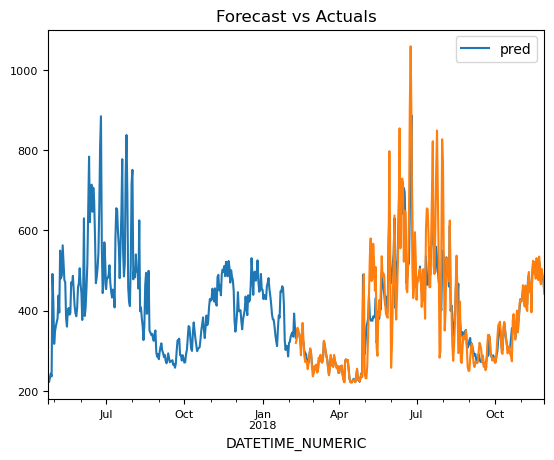

In [133]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
predictions_ss.plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)